<a href="https://colab.research.google.com/github/youssefokeil/Shoplifting-Detection/blob/main/Shoplifting-Detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**Setup and Dataset Download**:
We're going to try to grab the shortcut version of our dataset in 'MyDrive'

We'll first mount our notebook on google drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Now, is a good chance to import everything.

In [ ]:
import cv2
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from transformers import *
import torch
from pathlib import Path
from fastai.vision.all import *;

/usr/local/lib/python3.10/dist-packages/transformers/deepspeed.py:23: FutureWarning: transformers.deepspeed module is deprecated and will be removed in a future version. Please import deepspeed modules directly from transformers.integrations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation_utils.py:24: FutureWarning: Importing `GenerationMixin` from `src/transformers/generation_utils.py` is deprecated and will be removed in Transformers v4.40. Import as `from transformers import GenerationMixin` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation_tf_utils.py:24: FutureWarning: Importing `TFGenerationMixin` from `src/transformers/generation_tf_utils.py` is deprecated and will be removed in Transformers v4.40. Import as `from transformers import TFGenerationMixin` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation_flax_utils.py:24: FutureWarning: Importing `FlaxGenerationMixin` fr

## **Data Unzipping and Library Imports**

To get the data, we're going to use unzip terminal function.

In [ ]:
%%capture
! unzip /content/drive/MyDrive/dataset_clean.zip

In [ ]:
! pip install av;

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 32.9/32.9 MB 35.9 MB/s eta 0:00:00


In [ ]:
import imageio
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from skimage.transform import resize
import IPython.display as ipd

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
data_path=Path('/content/dataset_clean')

# **Preprocessing for Model Input:**
Extracts frames from videos, organizes them by labels (shoplifting vs. normal), and renames folders for consistency.



## Frame Extraction

Let's grab our videos paths using the `get_files()` function.

In [ ]:
videos_paths=get_files(data_path, extensions='.mp4')
videos_paths[0:5]

(#5) [Path('/content/dataset_clean/not Shop Lifters/shop_lifter_n_200.mp4'),Path('/content/dataset_clean/not Shop Lifters/shop_lifter_n_150.mp4'),Path('/content/dataset_clean/not Shop Lifters/shop_lifter_n_181.mp4'),Path('/content/dataset_clean/not Shop Lifters/shop_lifter_n_119.mp4'),Path('/content/dataset_clean/not Shop Lifters/shop_lifter_n_80.mp4')]

To properly make our extracted frames folder, we're going to use some `pathlib` functions. Let's first take one vide path.

In [ ]:
video_1=videos_paths[0]

In [ ]:
video_1.relative_to(video_1.parent.parent).with_suffix('')

Path('not Shop Lifters/shop_lifter_n_200')

This can be a proper path for whatever folder we're going to put our extracted frames in. Let's make oour parent folder.

In [ ]:
extracted_path=Path('/content/extracted_frames')
if not extracted_path.exists() : extracted_path.mkdir()

You can see if you've opened the folder window on the left, that we've made the folder that will contain the extracted frames. If you don't, right-click and click on refresh.

Now, it's time to make the function that will extract our frames, using openCV.

In [ ]:
def frames_one_vid(video_path, extracted_path=extracted_path, skip_frames=3):
    # Output directory named after the video file within the root output directory
    output_dir = extracted_path/video_path.relative_to(video_path.parent.parent).with_suffix('')
    if not output_dir.exists():
      output_dir.mkdir(parents=True, exist_ok=True)
      cap = cv2.VideoCapture(str(video_path))    #VideoCapture takes string as input not Path
      count = 0
      while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if count % (skip_frames + 1) == 0:  # Skip frames to reduce redundancy
            frame_path = os.path.join(output_dir, f'{count}.jpg')
            cv2.imwrite(frame_path, frame)
        count += 1
      cap.release()

Let's try this out, using `video_1`

In [ ]:
frames_one_vid(video_1)

Seems like everything worked out well, again if you don't see the extracted images, try to refresh yoyur folder window.

To speed up our operation, I am using fastai's `parallel` which parallelizes the operation. This may take some time.

In [ ]:
parallel(frames_one_vid,videos_paths)

(#347) [None,None,None,None,None,None,None,None,None,None...]

# **Another way: FastAI DataLoader Setup**
Uses FastAI to create DataLoaders, applying transformations to the video frames for model training.

# **The File Structure:**

    ├── extracted_frames
      ├── Normal
        ├── Shoplifting001_x264_0
          ├── 0.jpg
          ├── 1.jpg
          ...
        ├── Shoplifting001_x264_1
          ├── 0.jpg
          ├── 1.jpg
          ├── 10.jpg
          ...
        ...

      ├── Shoplifting
        ├── Shoplifting001_x264_10
          ├── 0.jpg
          ├── 1.jpg
          ├── 10.jpg
          ...
        ├── Shoplifting001_x264_11
          ├── 0.jpg
          ├── 1.jpg
          ├── 10.jpg
          ...
        ...

In [ ]:
def get_instances(path):
    " gets all instances folders paths"
    sequence_paths = []
    for actions in path.ls():
        sequence_paths += actions.ls()
    return sequence_paths

In [ ]:
instances_path = get_instances(extracted_path)
instances_path[0:3]

(#3) [Path('/content/extracted_frames/not Shop Lifters/shop_lifter_n_59'),Path('/content/extracted_frames/not Shop Lifters/shop_lifter_n_56'),Path('/content/extracted_frames/not Shop Lifters/shop_lifter_n_172')]

In [ ]:
@patch
def ls_sorted(self:Path):
    "ls but sorts files by name numerically"
    return self.ls().sorted(key=lambda f: int(f.with_suffix('').name))

In [ ]:
instances_path[0].ls_sorted()

(#50) [Path('/content/extracted_frames/not Shop Lifters/shop_lifter_n_59/0.jpg'),Path('/content/extracted_frames/not Shop Lifters/shop_lifter_n_59/4.jpg'),Path('/content/extracted_frames/not Shop Lifters/shop_lifter_n_59/8.jpg'),Path('/content/extracted_frames/not Shop Lifters/shop_lifter_n_59/12.jpg'),Path('/content/extracted_frames/not Shop Lifters/shop_lifter_n_59/16.jpg'),Path('/content/extracted_frames/not Shop Lifters/shop_lifter_n_59/20.jpg'),Path('/content/extracted_frames/not Shop Lifters/shop_lifter_n_59/24.jpg'),Path('/content/extracted_frames/not Shop Lifters/shop_lifter_n_59/28.jpg'),Path('/content/extracted_frames/not Shop Lifters/shop_lifter_n_59/32.jpg'),Path('/content/extracted_frames/not Shop Lifters/shop_lifter_n_59/36.jpg')...]

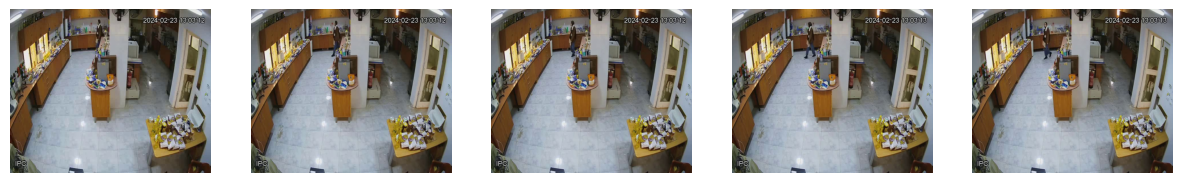

In [ ]:
frames = instances_path[0].ls_sorted()[0:5]
show_images([Image.open(img) for img in frames])

In [ ]:
class ImageTuple(fastuple):
    "A tuple of PILImages"
    def show(self, ctx=None, **kwargs):
        n = len(self)
        img0, img1, img2= self[0], self[n//2], self[n-1]
        if not isinstance(img1, Tensor):
            t0, t1,t2 = tensor(img0), tensor(img1),tensor(img2)
            t0, t1,t2 = t0.permute(2,0,1), t1.permute(2,0,1),t2.permute(2,0,1)
        else: t0, t1,t2 = img0, img1,img2
        return show_image(torch.cat([t0,t1,t2], dim=2), ctx=ctx, **kwargs)

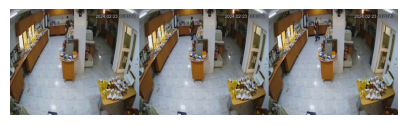

In [ ]:
ImageTuple(PILImage.create(fn) for fn in frames).show();

In [ ]:
class ImageTupleTfm(Transform):
    "A wrapper to hold the data on path format"
    def __init__(self, seq_len=20):
        store_attr()

    def encodes(self, path: Path):
        "Get a list of images files for folder path"
        frames = path.ls_sorted()
        n_frames = len(frames)
        s = slice(0, min(self.seq_len, n_frames))
        return ImageTuple(tuple(PILImage.create(f) for f in frames[s]))

In [ ]:
tfm = ImageTupleTfm(seq_len=5)
shoplifting_instance = instances_path[0]
shoplifting_instance

Path('/content/extracted_frames/not Shop Lifters/shop_lifter_n_59')

<Axes: >

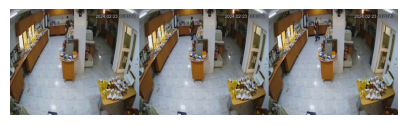

In [ ]:
tfm(shoplifting_instance).show()

In [ ]:
parent_label(shoplifting_instance)

'not Shop Lifters'

In [ ]:
def get_action_dataloaders(files, bs=8, image_size=64, seq_len=20, val_idxs=None, **kwargs):
    "Create a dataloader with `val_idxs` splits"
    splits = RandomSplitter()(files) if val_idxs is None else IndexSplitter(val_idxs)(files)
    itfm = ImageTupleTfm(seq_len=seq_len)
    ds = Datasets(files, tfms=[[itfm], [parent_label, Categorize]], splits=splits)
    dls = ds.dataloaders(bs=bs, after_item=[Resize(image_size), ToTensor],
                         after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)], drop_last=True, **kwargs)
    return dls

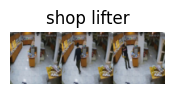

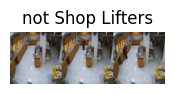

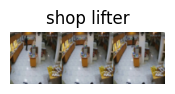

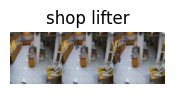

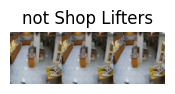

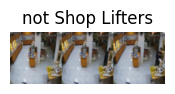

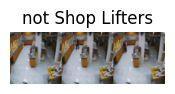

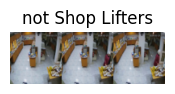

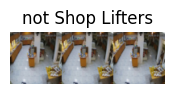

In [ ]:
dls = get_action_dataloaders(instances_path, bs=64, image_size=64, seq_len=100)
dls.show_batch()

# Baseline model
Now that we've made our dataloader, it's time to start making a baseline model. We'll start with a simple resnet fine tune it and use LSTM layers afterwards.

In [ ]:
class SimpleModel(Module):
    def __init__(self, arch=resnet34(), n_out=2):
        self.encoder = TimeDistributed(create_body(arch, pretrained=True))
        self.head = TimeDistributed(create_head(512, 2))
    def forward(self, x):
        x = torch.stack(x, dim=1)
        return self.head(self.encoder(x)).mean(dim=1)

def simple_splitter(model): return [params(model.encoder), params(model.head)]

In [ ]:
model=SimpleModel().cuda()

Now let's have a look at our dataset.

In [ ]:
x,y=dls.one_batch()

In [ ]:
len(x)

31

In [ ]:
x[0].shape

torch.Size([16, 3, 64, 64])

fastai's tutorials say that a loss function isn't necessary, because it's already embedded in our `DataLoaders`

In [ ]:
dls.loss_func

FlattenedLoss of CrossEntropyLoss()

Although we have only two classes, namely `normal`, `shoplifting`. CrossEntropyLoss() is good enough because a binary cross entropy is a special case of it.

To speed up our operation, we'll use `.to_fp16()` which approximates our 32 floating point number to 16 floating point only. On our way we're going to use approximations as much as we can to speed up our operations.

In [ ]:
learn = Learner(dls, model, metrics=[accuracy], splitter=simple_splitter).to_fp16()

In [ ]:
learn.fine_tune(3, 1e-3, freeze_epochs=3)

epoch,train_loss,valid_loss,accuracy,time
0,0.715292,0.651460,0.623188,00:21
1,0.664460,0.632983,0.565217,00:20
2,0.604020,0.572516,0.710145,00:20


epoch,train_loss,valid_loss,accuracy,time
0,0.581983,0.367769,0.840580,00:19
1,0.565895,0.277229,0.884058,00:19
2,0.503673,0.255478,0.913043,00:19


Notice that we used a random learning rate. To make better predictions we're going to leverage on fastai's `lr_finder` which is based on Leslie Smith's paper. Let's try this out. Every data has its own suitable learning rate.

---



In [ ]:
from fastai.test_utils import *

SuggestedLRs(valley=1.0964781722577754e-05, slide=0.14454397559165955)

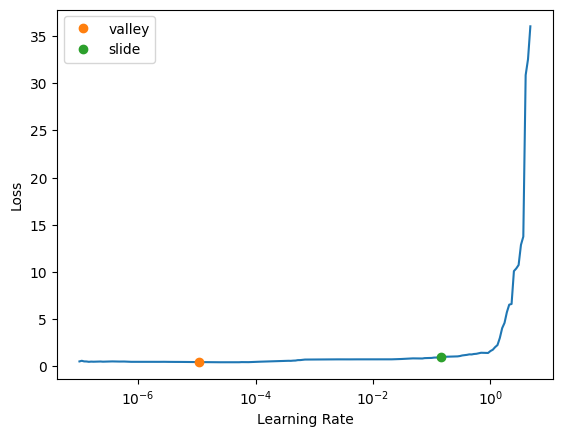

In [ ]:
learn.lr_find(suggest_funcs=(valley,slide),stop_div=False, num_it=200)  #may take some time

Try always to use `valley` and `slide` when looking for your learning rate, because fastai is often very conservative, when you take the valley it's actually far below what you can use. Remember, that a higher learning rate doesn't only make our model faster, it can improve the performance.

Here, we'll take an average of valley and slide

In [ ]:
min_grad_lr=0.072

In [ ]:
learn.fine_tune(6,min_grad_lr,freeze_epochs=1)

epoch,train_loss,valid_loss,accuracy,time
0,0.803161,0.664982,0.652174,00:19


epoch,train_loss,valid_loss,accuracy,time
0,0.727435,0.760150,0.362319,00:19
1,0.755186,0.635722,0.652174,00:19
2,0.729805,3.122567,0.652174,00:19
3,0.574909,0.492558,0.840580,00:20
4,0.431139,0.153225,0.927536,00:19
5,0.318437,0.091482,0.971014,00:20


This is pretty good for a model that doesn't store temporal data.Let's see how good our model performs.

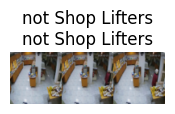

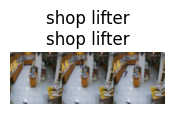

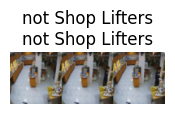

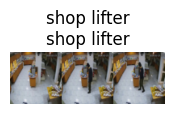

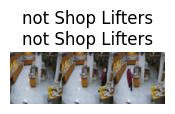

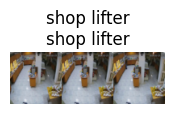

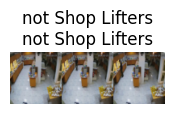

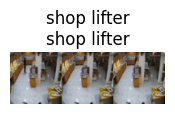

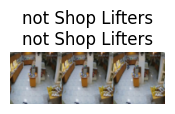

In [ ]:
learn.show_results()

## LSTM layer

Let's try and use LSTM layer to see how good our model performs.

In [ ]:
arch = resnet34()
encoder = nn.Sequential(create_body(arch, pretrained=True), nn.AdaptiveAvgPool2d(1), Flatten()).cuda()

In [ ]:
encoder(x[0]).shape

torch.Size([16, 512])

In [ ]:
class RNNModel(Module):
    def __init__(self, arch=resnet34(), n_out=2, num_rnn_layers=3):
        self.encoder = TimeDistributed(nn.Sequential(create_body(arch, pretrained=True), nn.AdaptiveAvgPool2d(1),nn.Dropout(0.15), Flatten()))
        self.rnn = nn.LSTM(512, 512, num_layers=num_rnn_layers, batch_first=True)
        self.head = LinBnDrop(num_rnn_layers*512, n_out)
    def forward(self, x):
        x = torch.stack(x, dim=1)
        x = self.encoder(x)
        bs = x.shape[0]
        _, (h, _) = self.rnn(x)
        return self.head(h.view(bs,-1))

In [ ]:
def rnnmodel_splitter(model):
    return [params(model.encoder), params(model.rnn)+params(model.head)]

In [ ]:
model2 = RNNModel().cuda()

In [ ]:
learn = Learner(dls, model2, metrics=[accuracy], splitter=rnnmodel_splitter).to_fp16()

In [ ]:
learn.lr_find(suggest_funcs=(valley,slide))

KeyboardInterrupt: 

In [ ]:
learn.fine_tune(30, 0.00025)

epoch,train_loss,valid_loss,accuracy,time
0,0.743661,0.767958,0.492754,01:12


epoch,train_loss,valid_loss,accuracy,time
0,0.857122,0.662907,0.521739,01:11
1,0.805411,0.705377,0.637681,01:11
2,0.807214,0.667439,0.608696,01:11
3,0.781007,0.723011,0.565217,01:11
4,0.774431,0.722554,0.478261,01:12
5,0.773169,0.673756,0.623188,01:11
6,0.771335,0.734732,0.565217,01:10
7,0.767973,0.699163,0.507246,01:12
8,0.762670,0.668878,0.666667,01:11
9,0.755930,0.672062,0.594203,01:11


KeyboardInterrupt: 

In [ ]:
learn.export()

In [ ]:
shoplifting_frames=Path('/content/extracted_frames/shop lifter/shop_lifter_0')

In [ ]:
shoplifting_frames

Path('/content/extracted_frames/shop lifter/shop_lifter_0')

In [ ]:
inferenced_learn=load_learner('/content/export.pkl', cpu=True)

In [ ]:
inferenced_learn=load_learner('/content/export.pkl', cpu=True)
_,tens_pred,_=inferenced_learn.predict(shoplifting_frames)
tens_pred.item()

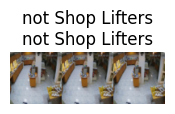

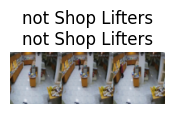

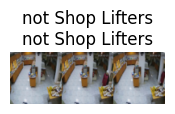

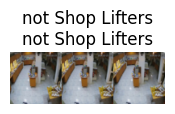

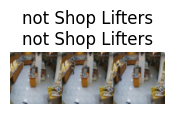

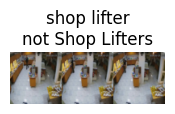

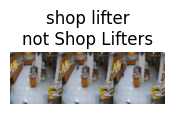

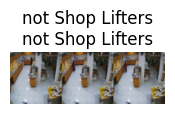

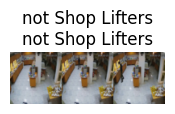

In [ ]:
learn.show_results()

In [ ]:
tens_pred.item()

1

#Reconsiderations

So we submitted our first model, which was using a resnet only. We got 24.6% accuracy and 40% precision. This is so bad for us, our model performs well on data it has already seen, but so bad on the test data. To train our model well we'll have to reconsider what we were doing.

## Making a test dataset

In the first chapter from FastAI's book. Jeremy Howard warned us of using the validation sets as our indication if our model is doing well. Because the hyperparameters like, learning rates, the optimizer, momentum are all parameters that depend on the validation set. This is considered cheating. So we'll have to make a test set, that only will be used to evaluate our model.

This can be done using some Unix-like Bash tricks

To do this we're going to add an extra line after we've downloaded our data, that moves some files to a test folder.

**Moving forward the notebook will assume you deleted your runtime and started from here.**
Let's download our data again

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import cv2
import numpy as np
import pandas as pd
import os
from sklearn.model_selection import train_test_split
from transformers import *
import torch
from pathlib import Path
from fastai.vision.all import *;

/usr/local/lib/python3.10/dist-packages/transformers/deepspeed.py:23: FutureWarning: transformers.deepspeed module is deprecated and will be removed in a future version. Please import deepspeed modules directly from transformers.integrations
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation_utils.py:24: FutureWarning: Importing `GenerationMixin` from `src/transformers/generation_utils.py` is deprecated and will be removed in Transformers v4.40. Import as `from transformers import GenerationMixin` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation_tf_utils.py:24: FutureWarning: Importing `TFGenerationMixin` from `src/transformers/generation_tf_utils.py` is deprecated and will be removed in Transformers v4.40. Import as `from transformers import TFGenerationMixin` instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/transformers/generation_flax_utils.py:24: FutureWarning: Importing `FlaxGenerationMixin` fr

In [ ]:
%%capture
! unzip /content/drive/MyDrive/dataset_clean.zip

In [ ]:
!pwd

/content


In [ ]:
%cd dataset_clean

/content/dataset_clean


In [ ]:
%cd 'shop lifter'

/content/dataset_clean/shop lifter


In [ ]:
%ls shop_lifter_1[12][0-9].mp4

shop_lifter_110.mp4*  shop_lifter_115.mp4*  shop_lifter_120.mp4*  shop_lifter_125.mp4*
shop_lifter_111.mp4*  shop_lifter_116.mp4*  shop_lifter_121.mp4*  shop_lifter_126.mp4*
shop_lifter_112.mp4*  shop_lifter_117.mp4*  shop_lifter_122.mp4*  shop_lifter_127.mp4*
shop_lifter_113.mp4*  shop_lifter_118.mp4*  shop_lifter_123.mp4*  shop_lifter_128.mp4*
shop_lifter_114.mp4*  shop_lifter_119.mp4*  shop_lifter_124.mp4*


In [ ]:
%mkdir ../../test

In [ ]:
%mv shop_lifter_1[12][0-9].mp4 ../../test

In [ ]:
%cd ../'not Shop Lifters'


/content/dataset_clean/not Shop Lifters


In [ ]:
%mv shop_lifter_n_1[7-9][0-9].mp4 ../../test

So we succeeded at making the test folder, let's now extract our frames of the rest of the videos, make our dataloaders and our Learner using transformers.

In [ ]:
%cd /content

/content


## Extract frames & dataloaders

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

### Extract frames

In [ ]:
data_path=Path('/content/dataset_clean')
videos_paths=get_files(data_path, extensions='.mp4')

In [ ]:
extracted_path=Path('/content/extracted_frames')
if not extracted_path.exists() : extracted_path.mkdir()

In [ ]:
def frames_one_vid(video_path, extracted_path=extracted_path, skip_frames=7):
    # Output directory named after the video file within the root output directory
    output_dir = extracted_path/video_path.relative_to(video_path.parent.parent).with_suffix('')
    if not output_dir.exists():
      output_dir.mkdir(parents=True, exist_ok=True)
      cap = cv2.VideoCapture(str(video_path))    #VideoCapture takes string as input not Path
      count = 0
      while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break
        if count % (skip_frames + 1) == 0:  # Skip frames to reduce redundancy
            frame_path = os.path.join(output_dir, f'{count}.jpg')
            cv2.imwrite(frame_path, frame)
        count += 1
      cap.release()

In [ ]:
parallel(frames_one_vid,videos_paths)

(#299) [None,None,None,None,None,None,None,None,None,None...]

### Dataloaders

In [ ]:
def get_instances(path):
    " gets all instances folders paths"
    sequence_paths = []
    for actions in path.ls():
        sequence_paths += actions.ls()
    return sequence_paths
instances_path = get_instances(extracted_path)

In [ ]:
class ImageTuple(fastuple):
    "A tuple of PILImages"
    def show(self, ctx=None, **kwargs):
        n = len(self)
        img0, img1, img2= self[0], self[n//2], self[n-1]
        if not isinstance(img1, Tensor):
            t0, t1,t2 = tensor(img0), tensor(img1),tensor(img2)
            t0, t1,t2 = t0.permute(2,0,1), t1.permute(2,0,1),t2.permute(2,0,1)
        else: t0, t1,t2 = img0, img1,img2
        return show_image(torch.cat([t0,t1,t2], dim=2), ctx=ctx, **kwargs)

In [ ]:
class ImageTupleTfm(Transform):
    "A wrapper to hold the data on path format"
    def __init__(self, seq_len=20):
        store_attr()

    def encodes(self, path: Path):
        "Get a list of images files for folder path"
        frames = path.ls_sorted()
        n_frames = len(frames)
        s = slice(0, min(self.seq_len, n_frames))
        return ImageTuple(tuple(PILImage.create(f) for f in frames[s]))

In [ ]:
@patch
def ls_sorted(self:Path):
    "ls but sorts files by name numerically"
    return self.ls().sorted(key=lambda f: int(f.with_suffix('').name))

In [ ]:
def get_action_dataloaders(files, bs=8, image_size=64, seq_len=20, val_idxs=None, **kwargs):
    "Create a dataloader with `val_idxs` splits"
    splits = RandomSplitter()(files) if val_idxs is None else IndexSplitter(val_idxs)(files)
    itfm = ImageTupleTfm(seq_len=seq_len)
    ds = Datasets(files, tfms=[[itfm], [parent_label, Categorize]], splits=splits)
    dls = ds.dataloaders(bs=bs, after_item=[Resize(image_size), ToTensor],
                         after_batch=[IntToFloatTensor, Normalize.from_stats(*imagenet_stats)], drop_last=True, **kwargs)
    return dls

In [ ]:
dls = get_action_dataloaders(instances_path, bs=64, image_size=64, seq_len=50)

## Transformer model

Sine our LSTM layer wasn't performing well even on our validation set. Our ResNet34 alone wasn't good enough for new data. We can try something new like a Transformer model.
Let's first download it.

In [ ]:
!pip install -Uq timesformer-pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.6/44.6 kB 1.5 MB/s eta 0:00:00


In [ ]:
from timesformer_pytorch import TimeSformer

To let our Transformer, or any model work well with our fastai `Learner` module. We'll have to make a forward method.

In [ ]:
class MyTimeSformer(TimeSformer):
    def forward(self, x):
        x = torch.stack(x, dim=1)
        return super().forward(x)

In [ ]:
timesformer = MyTimeSformer(
    dim = 128,
    image_size = 128,
    patch_size = 16,
    num_frames = 50,
    num_classes = 1,
    depth = 12,
    heads = 8,
    dim_head =  64,
    attn_dropout = 0.1,
    ff_dropout = 0.1
).cuda()

In [ ]:
precision=Precision()
recall=Recall()
learn_tf = Learner(dls, timesformer, metrics=[precision,recall,accuracy]).to_fp16()

In [ ]:
device=torch.device('cuda')

SuggestedLRs(valley=0.011659144423902035, slide=6.309573450380412e-07)

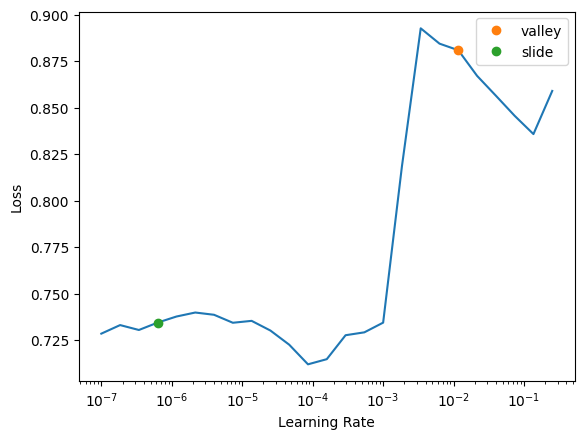

In [ ]:
learn_tf.lr_find(suggest_funcs=(valley,slide),num_it=30)

So, we're going to use a learning rate in the region off 1e-4

In [ ]:
learn_tf.fit_one_cycle(10,1e-04)

epoch,train_loss,valid_loss,precision_score,recall_score,accuracy,time


epoch,train_loss,valid_loss,precision_score,recall_score,accuracy,time
0,0.618613,0.704406,0.000000,0.000000,0.542373,01:19
1,0.630943,0.669647,0.000000,0.000000,0.542373,01:15
2,0.636330,0.720084,0.000000,0.000000,0.542373,01:16
3,0.638189,0.686993,0.000000,0.000000,0.542373,01:17


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision is ill-defin

KeyboardInterrupt: 

In [ ]:
def submit(folder,learner):
  model_prediction=[]
  '''
  Return:
  model_prediction -> list of zeros and ones based on the prediction for each video in the folder (0 -> not shop lifter | 1-> shop lifter)

  Args:
  folder_link -> link for a folder has some videos to predict

  '''

  # write your code here
  #---------------------------------------------------------------------------------------------------------
  # load your model weights
  inferenced_learn=learner
  # loop on all the videos in the folder_link
  video_paths=get_files(folder,extensions='.mp4')
  for path in video_paths:
    extracted_path=frames_one_vid(path)
    _,tens_pred,_=inferenced_learn.predict(extracted_path)
    int_pred=tens_pred.item()
 # append the predictions to the list model_prediction
    model_prediction.append(int_pred)

  # Note : the returned predictions should be 0 or 1 (0 -> not shop lifter | 1-> shop lifter)



  return [model_prediction,video_patha]

  #---------------------------------------------------------------------------------------------------------


